Regression and custom logging (metric, not-supported fiture)

# MLflow + Scikit-learn Regression 

This tutorial is based on the MLflow [ElasticNet Diabetes example](https://github.com/mlflow/mlflow/tree/master/examples/sklearn_elasticnet_diabetes). It illustrates how to use MLflow to track the model training process, including logging model parameters, metrics, the model itself, and other artifacts like plots. It also includes instructions for viewing the logged results in the MLflow tracking UI.    

This notebook uses the scikit-learn `diabetes` dataset and predicts the progression metric (a quantitative measure of disease progression after one year) based on BMI, blood pressure, and other measurements. It uses the scikit-learn ElasticNet linear regression model, varying the `alpha` and `l1_ratio` parameters for tuning.

### Supervised Regression with Scikit-learn
SKlearn is one of the most widely used python libraries for supervised regression, specifically for linear and tree-based algorithms. Linear models provide realtively simple tuning options but, when properly leveraged, are some of the most powerful traditional ML models with regards to predtive accuracy and support for statistical inference. 

### Elastic Net Regularization
This tutorial will focus on a common regualrization extension to mulitiple linear regression: **Elastic Net**. If you need a refresher and enjoy overly **TODO** videos, check out this [statsquest post](https://www.youtube.com/watch?v=1dKRdX9bfIo&ab_channel=StatQuestwithJoshStarmer) explaining the method.

ElasticNet is a regularization technique in supervised regression that combines L1 and L2 penalties. The **L1 penalty (Lasso)** encourages sparsity in the model coefficients, effectively performing feature selection by driving some coefficients to zero. The **L2 penalty (Ridge)** shrinks the coefficients towards zero, but not exactly to zero, promoting model robustness especially in cases of multicollinearity. ElasticNet blends these two approaches, allowing for both feature selection and regularization to manage correlated variables. 

$$\text{Elastic Net Penalty} = \alpha \cdot l1ratio \cdot \sum_{i=1}^{n} |\beta_i| + \frac{\alpha \cdot (1 - \text{l1\_ratio}}{2} \cdot \sum_{i=1}^{n} \beta_i^2$$

While manual intervention and monitoring is suggested, ElasticNet is one of the most reliable automated methods for removing mutlicolinearity in your feature space. **If you're using linear models and have lots of features, ElasticNet might be a good solution.**


In [1]:
!pip install --upgrade mlflow openpyxl shap

## Import required libraries and load dataset

In [2]:
import mlflow
from mlflow.models import make_metric

mlflow.sklearn.autolog(disable=True)  # Disable autologging - we will log manually

from itertools import cycle
import matplotlib.pyplot as plt
import pandas as pd
from pandas.io.formats.style import Styler
import numpy as np

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, enet_path
from sklearn import datasets
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

import subprocess
import tempfile

np.random.seed(42)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

In [3]:
# Load diabetes dataset
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target

# Create pandas DataFrame
Y = np.array([y]).transpose()
d = np.concatenate((X, Y), axis=1)
cols = ["age", "sex", "bmi", "bp", "s1", "s2", "s3", "s4", "s5", "s6", "progression"]
data = pd.DataFrame(d, columns=cols)

# Set MLflow globals
EXPERIEMNT_NAME = "elastic_net_diabetes_random_search_cv"  # The name of our MLflow experiment
MODEL_ARTIFACT_PATH = (
    "model"  # The name of the directory in our tracking server that stores our logged model
)

### The problem of multicolinearity

As mentioned above, multicolinearity is undesirable. 
* Linear solvers output coefficients that show a given vairables relationship with our label, holding all other values constant.
* If two variables have the same information i.e. are highly colinear, the "holding constant" component removes lots of signal from our feature
* Mathematically, it can be a bit complex to intuit this for multiple linear regression, but for OLS with a single predictor, the coefficient is directly proportional to pearson's correlation coefficient.

As shown above, pearson's correlation is covariance over the variance of x and y. 

In short, it least to instability of our model coefficients because linear coefficients show 

Ordinary Least Squares (OLS) is a optimization technique that shows values for our coefficients. One of the most powerful 

## Create function to plot ElasticNet descent path

Quickly, here is some background on our method. ElasticNet is a regularization technique in supervised regression that combines L1 and L2 penalties, known as Lasso and Ridge regression respectively. The **L1 penalty (Lasso)** encourages sparsity in the model coefficients, effectively performing feature selection by driving some coefficients to zero. The **L2 penalty (Ridge)** shrinks the coefficients towards zero, but not exactly to zero, promoting model robustness especially in cases of multicollinearity. ElasticNet blends these two approaches, allowing for both feature selection and regularization to manage correlated variables. This makes ElasticNet particularly valuable for models where both the number of predictors and their collinearity might affect the predictive performance and interpretability.

To observe the effect our L1 and L2 penalization sklearn exposes two parameters of interest:
* **Mixing parameter (lambda)**: Number between 0 and 1 passed to elastic net which determines the ratio between ridge and Lasso.
* **Alpha**: Number that multiplies the penalty terms. A larger alpha leads to more regularization from both L1 and L2 penalties. 

$$\frac{1}{2 \cdot n_{\text{samples
}}} \cdot \left\|y - Xw\right\|_2^2 + \alpha \cdot l1_{\text{ratio}} \cdot \left\|w\right\|_1 + 0.5 \cdot \alpha \cdot (1 - \rho) \cdot \left\|w\right\|_2^2$$

### EDA

Exploratory Data Analysis (EDA) is an important and difficult component of model development. It's
often hard to predict what charts or summary statistics will be relevant to a modeling process, 
especially if the user is unfamiliar with the technique or data. 

Given the above point and cloud storage is cheap, let's demonstrate a fairly comprehensive set of 
diagnostics for our ElasticNet process. Note that these metrics are not exhuasitve and some are
redundant. However, by the end of this tutorial you should be comfortable customizing MLflow's 
logging features to store any relevant metadata.

Let's walk through some examples of diagnostics.

In [4]:
def get_summary_statistics(df: pd.DataFrame) -> pd.DataFrame:
    """Return summary statistics for the DataFrame."""
    return df.describe()


def get_correlation_heatmap(df: pd.DataFrame) -> Styler:
    """Return a heatmap of the correlation matrix."""
    return df.corr().style.background_gradient(cmap="Blues")


def get_enet_descent_path_plot(
    X: np.array, y: np.array, l1_ratio: float, column_names: list
) -> plt.Figure:
    """Return a plot of the descent path."""
    # Compute paths
    eps = 5e-3  # the smaller it is the longer is the path
    alphas_enet, coefs_enet, _ = enet_path(X, y, eps=eps, l1_ratio=l1_ratio)

    # Create and return our plot
    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()

    colors = cycle(["b", "r", "g", "c", "k", "y", "m", "orange", "purple", "brown"])
    neg_log_alphas_enet = -np.log10(alphas_enet)
    lines = []
    for coef_e, c, name in zip(coefs_enet, colors, column_names):
        line = plt.plot(neg_log_alphas_enet, coef_e, linestyle="--", c=c, label=name)
        lines.append(line)

    plt.xlabel("-Log(alpha)")
    plt.ylabel("Coefficients")
    title = "ElasticNet Paths for l1_ratio = " + str(l1_ratio)
    plt.title(title)
    plt.legend(loc="best")
    plt.axis("tight")

    plt.close(fig)

    return fig


def p90_of_residuals() -> mlflow.metrics.EvaluationMetric:
    """Return a custom MLflow metric for the 90th percentile of residuals."""

    def _p90_of_residuals_eval_fn(predictions: pd.Series, targets: pd.Series) -> float:
        return np.percentile(predictions - targets, 90)

    return make_metric(
        eval_fn=_p90_of_residuals_eval_fn,
        greater_is_better=True,
        name="90th_percentile_of_residuals",
    )

Based on the summary statistics below, we can see our features have the same scale, which is
consistent with the [sklearn docs](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset).

In [5]:
data.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
count,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000,442.000
mean,-0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,152.133
std,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,0.048,77.093
min,-0.107,-0.045,-0.090,-0.112,-0.127,-0.116,-0.102,-0.076,-0.126,-0.138,25.000
25%,-0.037,-0.045,-0.034,-0.037,-0.034,-0.030,-0.035,-0.039,-0.033,-0.033,87.000
50%,0.005,-0.045,-0.007,-0.006,-0.004,-0.004,-0.007,-0.003,-0.002,-0.001,140.500
75%,0.038,0.051,0.031,0.036,0.028,0.030,0.029,0.034,0.032,0.028,211.500
max,0.111,0.051,0.171,0.132,0.154,0.199,0.181,0.185,0.134,0.136,346.000


Based on the correlation heatmap below, we can see that some features are highly correlated. We'll
look to resolve the multicolinearity with regularization.

In [6]:
get_correlation_heatmap(data)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,progression
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


Based on the descent path plot below, we can see an even spread between our feature coefficients
as alpha increases. Alpha corresponds to __strength__ of our regularization, and we can see greater
regularization leads to more extreme coeffient value (with an ``l1_ratio`` of 0.5).

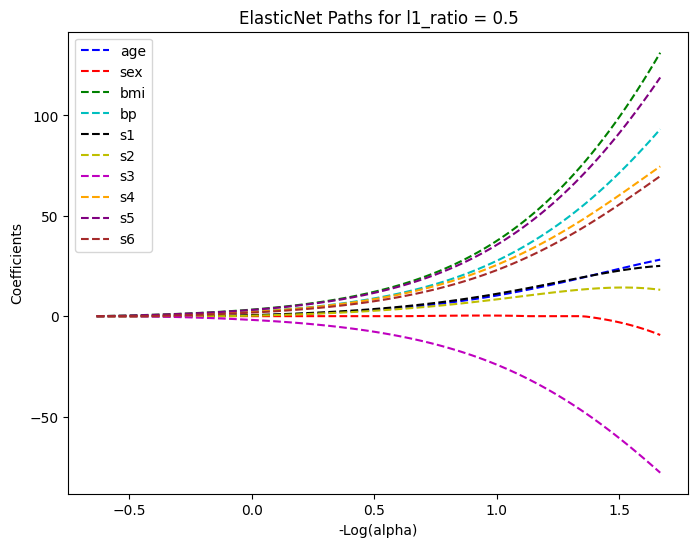

In [7]:
get_enet_descent_path_plot(X, y, 0.5, cols[:-1])

## Leverage RandomSearch CV to Train

Next, we will fit many models with different parameters using SKlearn's RandomizedSearchCV. The 
RandomizedSearchCV class in scikit-learn is used to perform randomized search on a given hyperparameter space.
It randomly samples a specified number of combinations from the hyperparameter space and evaluates them using cross-validation.
This helps in finding the best combination of hyperparameters for a machine learning model.

For more information, refer to the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

To allow for custom logging with RandomizedSearchCV, we are going to build a custom wrapper around 
SKlearn's ElasticNet regularization. During the fit process, we will add all our logging calls.





In [ ]:
def log_styler_as_xlsx(styler_object: Styler, artifact_name: str):
    """Log a pandas styler object as an .xlsx MLflow artifact."""

    suffix = ".xlsx"

    with tempfile.NamedTemporaryFile(suffix=suffix) as tmpfile:
        # Store the styler object in a temp file
        styler_object.to_excel(tmpfile.name)

        # Log the artifact from the tempfile path as an artifact
        mlflow.log_artifact(tmpfile.name, artifact_name + suffix)


def train_diabetes(
    train_X: pd.DataFrame, train_y: pd.DataFrame, alpha: float, l1_ratio: float
) -> pd.DataFrame:
    """
    Trains an ElasticNet model on diabetes dataset, logs the model, and additional figures to MLflow.
    """

    # Start an MLflow run; the "with" keyword ensures we'll close the run even if this cell crashes
    with mlflow.start_run(nested=True):
        # Train our model
        lr = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        lr.fit(train_X, train_y)

        # Log our hyperparameters of interest
        mlflow.log_params({"alpha": alpha, "l1_ratio": l1_ratio})

        # Log mlflow model (and register the model)
        model_info = mlflow.sklearn.log_model(
            lr,
            MODEL_ARTIFACT_PATH,
            input_example=train_X.head(),
        )

        # Log the coefficients dict
        model_coefficients = {feature: coef for feature, coef in zip(train_X.columns, lr.coef_)}
        mlflow.log_dict(model_coefficients, "model_coefficients.json")

        # Log the data summary statistics table
        summary_stats = pd.concat([train_X, train_y], axis=1).describe()
        mlflow.log_table(summary_stats, "summary_stats.json")

        # Log the descent path figure
        descent_path_figure = get_enet_descent_path_plot(
            train_X.to_numpy(), train_y.to_numpy().reshape(-1), l1_ratio, train_X.columns
        )
        mlflow.log_figure(descent_path_figure, "descent_path.png")

        # Log the correlation heatmap figure using the custom logging method
        correlation_heatmap_figure = get_correlation_heatmap(pd.concat([train_X, train_y], axis=1))
        log_styler_as_xlsx(correlation_heatmap_figure, "correlation_heatmap")

        # Log a vanilla sklearn metric
        mlflow.log_metric("sklearn_mse", mean_squared_error(train_y, lr.predict(train_X)))

        # Log evaluate default and custom p90_of_residuals metrics
        mlflow.evaluate(
            model=model_info.model_uri,
            model_type="regressor",
            data=pd.concat([train_X, train_y], axis=1),
            targets="progression",
            evaluators=["default"],
            extra_metrics=[p90_of_residuals()],
        )

        # Return trained model URI so we can load it from the tracking server
        return model_info.model_uri


class ElasticNetCustom(BaseEstimator, RegressorMixin):
    def __init__(self, alpha: float = 1.0, l1_ratio: float = 0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio
        self.model = None

    def fit(self, X, y):
        # Train the model and get the URI
        model_uri = train_diabetes(X, y, self.alpha, self.l1_ratio)

        # Load the model from the model registry based on the URI
        self.model = mlflow.sklearn.load_model(model_uri)

        return self

    def predict(self, X):
        if self.model is not None:
            return self.model.predict(X)
        else:
            raise ValueError(
                "Model has not been fit yet. You must call `.fit()` before `.predict()`"
            )

At a high level, the above code creates a new ``ElasticNetCustom`` class that defines ``fit`` and
``predict`` methods. The reason we create a custom implementation is we want to invoke custom 
logging every time a training CV iteration is invoked.

Let's see how we can pass this custom class to ``RandomSearchCV``.

In [13]:
# Assuming you have a DataFrame `data` ready to be used
param_distributions = {
    "alpha": uniform(0.0001, 1.0),  # Uniform distribution over alpha
    "l1_ratio": uniform(0, 1),  # Uniform distribution over l1_ratio
}

# Instantiate the custom ElasticNet wrapper
elastic_net_custom = ElasticNetCustom()

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    elastic_net_custom,
    param_distributions,
    random_state=42,
    error_score="raise",
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
)

# Assuming `X` and `y` are your features and target variable
# Split the data into training and test sets. (0.75, 0.25) split.
train, test = train_test_split(data)

# The predicted column is "progression" which is a quantitative measure of disease progression one year after baseline
train_X = train.drop(["progression"], axis=1)
test_X = test.drop(["progression"], axis=1)
train_y = train[["progression"]]
test_y = test[["progression"]]

# Set an experiment name for easy access
mlflow.set_experiment(EXPERIEMNT_NAME)

# Kick off our RandomizedSearchCV
random_search.fit(train_X, train_y)

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
Setuptools is replacing distutils.
2024/02/28 19:52:48 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/02/28 19:52:48 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/02/28 19:52:48 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/02/28 19:52:48 INFO mlflow.models.evaluation.default_evaluator: Evaluating metrics: 90th_percentile_of_residuals
2024/02/28 19:52:48 INFO mlflow.models.evaluation.default_evaluator: Shap explainer LinearExplainer is used.
Unable to serialize underlying model using MLf

RandomizedSearchCV(error_score='raise', estimator=ElasticNetCustom(),
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbe48a156d0>,
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7fbe129fda90>},
                   random_state=42,
                   scoring=make_scorer(mean_squared_error, greater_is_better=False))

Now that our training is complete, let's observe the logged information in a pandas DataFrame.

In [ ]:
# Get all runs from the experiment in a pd.DataFrame
runs = mlflow.search_runs(
    experiment_names=[EXPERIEMNT_NAME], search_all_experiments=True
)
print(f"Logged run information: {list(runs.columns)}")

# Add the model URI to the DataFrame
runs["model_uri"] = "runs:/" + runs["run_id"] + "/model"

# Show the DataFrame with only the columns of interest
columns_of_interest = [
    c for c in runs.columns if c.startswith("metrics") or c.startswith("params")
] + ["run_id", "model_uri"]
runs_summary = runs[columns_of_interest].sort_values(
    "metrics.root_mean_squared_error", ascending=True
)
runs_summary

Logged run information: ['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time', 'end_time', 'metrics.max_error', 'metrics.r2_score', 'metrics.mean_on_target', 'metrics.mean_absolute_percentage_error', 'metrics.sklearn_mse', 'metrics.mean_absolute_error', 'metrics.root_mean_squared_error', 'metrics.sum_on_target', 'metrics.90th_percentile_of_residuals', 'metrics.mean_squared_error', 'metrics.score', 'metrics.example_count', 'params.l1_ratio', 'params.alpha', 'tags.mlflow.log-model.history', 'tags.mlflow.loggedArtifacts', 'tags.mlflow.runName', 'tags.mlflow.source.name', 'tags.mlflow.user', 'tags.mlflow.datasets', 'tags.mlflow.source.type']


,metrics.max_error,metrics.r2_score,metrics.mean_on_target,metrics.mean_absolute_percentage_error,metrics.sklearn_mse,metrics.mean_absolute_error,metrics.root_mean_squared_error,metrics.sum_on_target,metrics.90th_percentile_of_residuals,metrics.mean_squared_error,metrics.score,metrics.example_count,params.l1_ratio,params.alpha,run_id,model_uri
24,142.200,0.555,156.615,0.380,2727.761,42.525,52.228,41503.000,62.842,2727.761,0.555,265.000,0.9699098521619943,0.020684494295802446,814e4cdc4f724bb69bdaf7354b368b04,runs:/814e4cdc4f724bb69bdaf7354b368b04/model
25,134.197,0.551,155.451,0.393,2799.928,43.404,52.914,41039.000,62.385,2799.928,0.551,264.000,0.9699098521619943,0.020684494295802446,90684bb86e99455789858b8b7e6a0b99,runs:/90684bb86e99455789858b8b7e6a0b99/model
21,139.757,0.521,154.732,0.383,2809.975,43.311,53.009,41004.000,64.823,2809.975,0.521,265.000,0.9699098521619943,0.020684494295802446,baa4d7dd30a641159e072f144041279f,runs:/baa4d7dd30a641159e072f144041279f/model
0,141.825,0.543,154.486,0.394,2839.738,43.451,53.289,51135.000,66.362,2839.738,0.543,331.000,0.9699098521619943,0.020684494295802446,4b5e625e471e4a38a630d5d376768eb7,runs:/4b5e625e471e4a38a630d5d376768eb7/model
22,141.256,0.561,153.891,0.401,2861.810,43.656,53.496,40781.000,66.057,2861.810,0.561,265.000,0.9699098521619943,0.020684494295802446,5a119c8402c5454c98ffadfd838e412d,runs:/5a119c8402c5454c98ffadfd838e412d/model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,190.760,0.023,153.891,0.656,6369.107,68.813,79.807,40781.000,92.793,6369.107,0.023,265.000,0.2912291401980419,0.43204501864211575,e2456e768167408bb40033ef0a8dfc3c,runs:/e2456e768167408bb40033ef0a8dfc3c/model
59,190.783,0.019,153.891,0.657,6391.640,68.940,79.948,40781.000,93.113,6391.640,0.019,265.000,0.5986584841970366,0.7320939418114051,0ead9fe4da554a83ac672225b5ccbc1a,runs:/0ead9fe4da554a83ac672225b5ccbc1a/model
42,190.783,0.019,153.891,0.657,6391.640,68.940,79.948,40781.000,93.113,6391.640,0.019,265.000,0.5986584841970366,0.7320939418114051,401c17d979fd41fda1f1b2308b2106fa,runs:/401c17d979fd41fda1f1b2308b2106fa/model
17,191.479,0.011,153.891,0.660,6448.812,69.250,80.304,40781.000,93.890,6448.812,0.011,265.000,0.21233911067827616,0.8325426408004217,5065fdaa41c745f19937f50a9244ad0f,runs:/5065fdaa41c745f19937f50a9244ad0f/model


SKlearn's ``RandomSearchCV`` also provides metadata about our hyperparameter search. Let's ensure
that the best hyper parameters logged to MLflow are the same as those stored in our ``random_search``
object.

In [ ]:
formatted_runs_summary = runs_summary[['params.alpha','params.l1_ratio']].iloc[0].astype(float)
formatted_runs_summary.index = ["alpha", "l1_ratio"]
print(f"MLflow logged params:                    {dict(formatted_runs_summary)}")
print(f"SKlearn RandomSearchCV object params:    {random_search.best_params_}")


MLflow logged params:                    {'alpha': 0.020684494295802446, 'l1_ratio': 0.9699098521619943}
SKlearn RandomSearchCV object params:    {'alpha': 0.020684494295802446, 'l1_ratio': 0.9699098521619943}


Finally, let's go the the MLflow UI by running the below command. By doing so, we can interact with
our experiment runs via the UI.

The above information is available in the ``random_search`` object we fit above, but because we've logged this information to the tracking server, it will persist after you exit session and can be easily shared and explored by collaborators (including future "you").

In [18]:
subprocess.call(["mlflow","server"])

/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/pydantic/_internal/_config.py:317: UserWarning: Valid config keys have changed in V2:
* 'schema_extra' has been renamed to 'json_schema_extra'
  warnings.warn(message, UserWarning)
[2024-02-28 20:01:31 -0500] [43482] [INFO] Starting gunicorn 21.2.0
[2024-02-28 20:01:31 -0500] [43482] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-02-28 20:01:31 -0500] [43482] [ERROR] Retrying in 1 second.
[2024-02-28 20:01:32 -0500] [43482] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-02-28 20:01:32 -0500] [43482] [ERROR] Retrying in 1 second.
[2024-02-28 20:01:33 -0500] [43482] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-02-28 20:01:33 -0500] [43482] [ERROR] Retrying in 1 second.
[2024-02-28 20:01:34 -0500] [43482] [ERROR] Connection in use: ('127.0.0.1', 5000)
[2024-02-28 20:01:34 -0500] [43482] [ERROR] Retrying in 1 second.
[2024-02-28 20:01:35 -0500] [43482] [ERROR] Connection in use: ('127.0.0.1'

1

2024/02/28 20:18:16 ERROR mlflow.server: Exception on /ajax-api/2.0/mlflow/model-versions/search [GET]
Traceback (most recent call last):
  File "/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/flask/app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
  File "/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/flask/app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/flask/app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
  File "/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/flask/app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "/Users/michael.berk/opt/anaconda3/envs/mlflow-dev-1/lib/python3.8/site-packages/mlflow/server/handlers.py", line 494, in wr

To see your runs, follow the below steps:
1. Navigate to the ``Experiments`` tab, which can be found on the header.
2. Navigate to our experiment of interest. In our case, it will take the value of our global variable ``EXPERIMENT_NAME``.
3. Click on any experiment run.
4. Observe the logged information.

More specifically, you should see the following information:
* A logged dataset
* 2 logged paramters, ``alpha`` and ``l1_ratio``
* 12 metrics. To validate our metrics of interest, observe...
    * ``sklearn_mse``, which we logged manually via ``mlflow.log_param()``
    * ``90th_percentile_of_residuals``, which was a custom eval function logged via ``mlflow.evaluate()``
    * Metrics associated with ``mlflow.evaluate()`` defaults, such as ``r2_score`` and ``sum_on_target``
* A variety of artifacts, for instance...
    * ``correlation_heatmap.xlsx`` which was logged via our custom ``log_styler_as_xlsx()`` function
    * ``model``, which was logged via ``mlflow.log_model()`` and contains lots of useful metadata about our model
    * ``descent_path.png``, which was logged via ``mlflow.log_figure()``
    * ``model_coefficients.json``, which was logged via ``mlflow.log_dict``
    * Three SHAP plots explaining our features, for instance ``shap_beeswarm_plot.png``. These were logged by default via ``mlflow.evaluate()``
    * ``summary_stats.json``, which was logged via ``mlflow.log_table()``

# Optimal params from the sklearn object
print(random_search.best_score_)
print(random_search.best_params_)

# Optimal params from the MLflow tracking server


### Next Steps
As noted above, this notebook looks to demonstrate how to leverage MLflow to develop models in a scalable and reproducible manner. That said, production systems are complex and we omitted many important topics. Here are a few notes on those topics.

Methodology Notes
* When using ElasticNet, statistical signifigance of the coefficients is importantant. SKlearn does not provide coefficient statisitical signfigance calculations out of the box, we we recommend using [statsmodels](https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.fit_regularized.html) or calculating these p-values manually. 
* Our above method does not include a hold-out valdiation set e.g. a dataset to report final accuracy where we only fit once. There is some debate as to the importance of this final step, however if you are relying on the statistical inference of this model, it's important to follow best practices.

MLflow Methodology Notes
* After initial EDA, you have can automate hyperparameter tuning natively in [MLFlow](https://mlflow.org/docs/latest/traditional-ml/hyperparameter-tuning-with-child-runs/index.html)
* When using this model for batch inference, you can simply load the desired model version from the model registry and apply that over your dataframe. 
* When using this model for realtime inference, you can leverage a serving environment.


## View the experiment, run, and notebook revision in the MLflow UI
To view the results, click **Experiment** at the upper right of this page. The Experiments sidebar appears. This sidebar displays the parameters and metrics for each run of this notebook. Click the circular arrows icon to refresh the display to include the latest runs. 

To view the notebook experiment, which contains a list of runs with their parameters and metrics, click the square icon with the arrow to the right of **Experiment Runs**. The Experiment page displays in a new tab. The **Source** column in the table contains a link to the notebook revision associated with each run.

To view the details of a particular run, click the link in the **Start Time** column for that run. Or, in the Experiments sidebar, click the icon at the far right of the date and time of the run. 

For more information, see "View notebook experiment" ([AWS](https://docs.databricks.com/applications/mlflow/tracking.html#view-notebook-experiment)|[Azure](https://docs.microsoft.com/azure/databricks/applications/mlflow/tracking#view-notebook-experiment)|[GCP](https://docs.gcp.databricks.com/applications/mlflow/tracking.html#view-notebook-experiment)).